In [1]:
import scipy, time, random, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.data_parser import *
from common.misc import *
import companies_data_preprocessor

In [2]:
def replace_missing_vals(df):
    for col in df:
        for entry in df[col]:
            if entry != True:
                df[col][entry] = 0
    return df

In [3]:
df = parse_companies(5)
data, labels = companies_data_preprocessor.preprocess(df, MinMaxScaling=False)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1 )

In [4]:
def analyze_model(model, x_test):
    prediction = pd.DataFrame()
    prediction["class"] = model.predict(x_test)
    

    accuracy = compare_df(prediction, y_test, "class")[0]
    confusion_mat = confusion_matrix(y_test, prediction)
    cost = companies_data_preprocessor.calculate_score(confusion_mat)

    return [accuracy, cost]

Best score:  1.8646362098138747


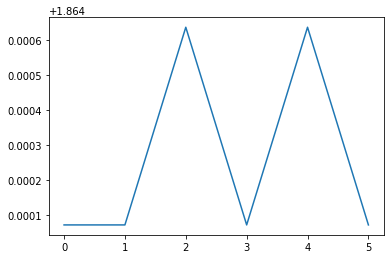

In [5]:
max_k = 40
min_k = 35
results = []
for k in range(min_k, max_k+1):
    model = KNeighborsClassifier(n_neighbors=k, weights="uniform").fit(x_train, y_train)
    results.append(analyze_model(model, x_test))
    
results = pd.DataFrame(results, columns=["accuracy", "cost"])
plt.plot(results["cost"])
best_index = results["cost"].argmax()
print("Best score: ", results.iloc[best_index]["cost"])